In [1]:
import pandas as pd

def fetch_titanic_data (type:str="train", passenger_id:bool = True) -> pd.DataFrame:
    """
        Festches the data from the the folder and outputs it as a pandas dataframe
    Args:
        type (str, optional): This is the type of data you would like to work with, either train or test. Defaults to "train" | "test".
        passenger_id (bool, optional): This is to determine if you would want the passenger id to be the index. Defaults to True.

    Returns:
        pd.DataFrame: _description_
    """
    df = pd.read_csv(f"titanic_data/{type}.csv")
    if passenger_id:
        df.set_index("PassengerId", inplace=True)
    return df

In [2]:
train_data = fetch_titanic_data(type="train", passenger_id=True)

In [3]:
train_data.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_data.isnull().sum() / len(train_data)

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

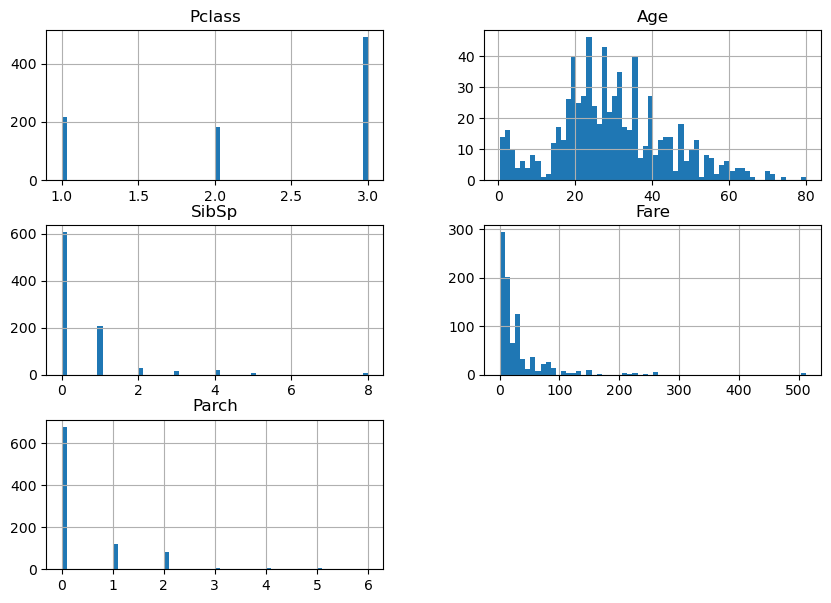

In [6]:
train_data[['Pclass', 'Age', "SibSp", "Fare", "Parch"]].hist(bins=60, figsize=(10,7));

In [7]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [8]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [9]:
train_data["Parch"].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [10]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

# Defining Pipeline

In [11]:
y_train = train_data["Survived"].copy()
x_train = train_data.drop("Survived", axis=1)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [13]:
from sklearn.base import TransformerMixin, BaseEstimator

class ColumnSelector(TransformerMixin, BaseEstimator):

    def __init__(self, columns, desired) -> None:
        super().__init__()
        self.columns = columns
        self.desired = desired
        return None
    
    def fit(self, x,y=None):
        return self
    
    def transform(self, x,y=None):
        df = pd.DataFrame()
        for num,col in enumerate(self.columns):
            if col in self.desired:
                df[col] = x[:,num]
        return df

In [14]:
col = ColumnSelector(columns=list(train_data.columns), desired=["Age", "SibSp", "Parch", "Fare"])

In [15]:
col.fit_transform(train_data.values)

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.25
1,38.0,1,0,71.2833
2,26.0,0,0,7.925
3,35.0,1,0,53.1
4,35.0,0,0,8.05
...,...,...,...,...
886,27.0,0,0,13.0
887,19.0,0,0,30.0
888,NaN,1,2,23.45
889,26.0,0,0,30.0


In [16]:
from sklearn.compose import ColumnTransformer
import numpy as np

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

data_preparation_pipeline = ColumnTransformer([
    ("num_pipeline", num_pipeline, num_attribs),
    ("cat_pipeline", cat_pipeline, cat_attribs)
])

full_data_preparation_pipeline = Pipeline([
    ("column_selector", ColumnSelector(columns=np.array(x_train.columns), desired=num_attribs + cat_attribs)),
    ("data_preparation", data_preparation_pipeline)
])

In [17]:
x_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [18]:
x_train_prepared = full_data_preparation_pipeline.fit_transform(x_train.values)

c:\Users\Metron\Desktop\ML\ml_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

models = {
    "log_reg": LogisticRegression(),
    "d_tree":DecisionTreeClassifier(),
    "forrest":RandomForestClassifier(random_state=42),
    "svc":SVC()
}

class ModelSelector():

    def __init__(self, models:dict = models, x=x_train_prepared, y=y_train) -> None:
        self.models = models
        self.x = x
        self.y = y

    def train_models(self,cv):
        df = pd.DataFrame(index=["f1", "accuracy"])
        for model in self.models:
            print(f"Training {model}")
            model_score = cross_val_predict(self.models[model], self.x, self.y, cv=cv)
            f1 = f1_score(y_train, model_score)
            accuracy = accuracy_score(y_train, model_score)
            results = np.array([f1,accuracy])
            results.reshape(2,1)
            df[model] = results
        return df
    

In [20]:
selector = ModelSelector()

results = selector.train_models(cv=10)

Training log_reg
Training d_tree
Training forrest
Training svc


In [21]:
results

,log_reg,d_tree,forrest,svc
f1,0.727549,0.722714,0.745509,0.756250
accuracy,0.799102,0.789001,0.809203,0.824916


In [22]:
from sklearn.model_selection import cross_val_score
svc_clf = SVC()
svm_scores = cross_val_score(svc_clf, x_train_prepared, y_train, cv=10)

In [23]:
frst_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(frst_clf, x_train_prepared, y_train, cv=10)

In [39]:
from sklearn.ensemble import VotingClassifier
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()

v_clf = VotingClassifier(
    estimators=[("svc", svc_clf), ("rf", frst_clf), ("d_tree", d_tree), ("log_reg", log_reg)],
    voting="hard"
)
v_clf.fit(x_train_prepared, y_train)

VotingClassifier(estimators=[('svc', SVC()),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('d_tree', DecisionTreeClassifier()),
                             ('log_reg', LogisticRegression())])

In [40]:
v_preds = cross_val_score(v_clf, x_train_prepared, y_train, cv=10)

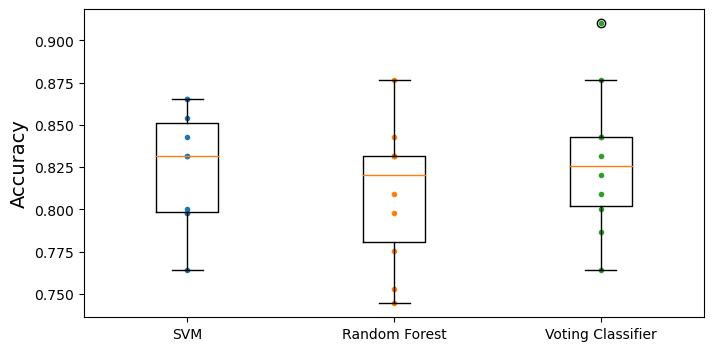

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.plot([3]*10, v_preds, ".")
plt.boxplot([svm_scores, forest_scores, v_preds], labels=("SVM","Random Forest", "Voting Classifier"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [48]:
full_prediction_pipeline = Pipeline([
    ("precessing", full_data_preparation_pipeline),
    ("predictor", v_clf)
])

In [ ]:
param_grid = [{
    "predictor__svc__C": [0.1, 1, 10, 100, 1000],
    "predictor__svc__gamma": [1, 0.1, 0.01, 0.001],
    "predictor__svc__kernel":["rbf"], 
}]
from sklearn.model_selection import GridSearchCV

grid_search_prep = GridSearchCV(full_prediction_pipeline, param_grid, cv=5,
                                scoring='accuracy', verbose=2)
grid_search_prep.fit(x_train.values, y_train)

In [68]:
grid_search_prep.best_estimator_

Pipeline(steps=[('precessing',
                 Pipeline(steps=[('column_selector',
                                  ColumnSelector(columns=array(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'], dtype=object),
                                                 desired=['Age', 'SibSp',
                                                          'Parch', 'Fare',
                                                          'Pclass', 'Sex',
                                                          'Embarked'])),
                                 ('data_preparation',
                                  ColumnTransformer(transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('impute',...
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('cat_encoder',
                                                                                    OneHotEncoder(sparse=False))]),
                                                                   ['Pclass',
                                                                    'Sex',
                                                                    'Embarked'])]))])),
                ('predictor',
                 VotingClassifier(estimators=[('svc', SVC(C=1, gamma=0.1)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=9,
                                                                      max_leaf_nodes=9,
                                                                      n_estimators=25,
                                                                      random_state=42)),
                                              ('d_tree',
                                               DecisionTreeClassifier()),
                                              ('log_reg',
                                               LogisticRegression())]))])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
final_model = grid_search_prep.best_estimator_
preds = final_model.predict(x_train.values)

conf_m = confusion_matrix(y_train, preds)

ConfusionMatrixDisplay(conf_m).plot()

In [70]:
test_data = fetch_titanic_data(type="test", passenger_id=False)

In [71]:
p_id = test_data["PassengerId"].copy()
test_data.drop("PassengerId", axis=1, inplace=True)

In [72]:
predictions = final_model.predict(test_data.values)

In [73]:
submission = pd.DataFrame({
    "PassengerId":p_id,
    "Survived":predictions
})

In [74]:
submission.to_csv("titanic_data/submit1.csv", index=False)